<a href="https://colab.research.google.com/github/ozeiasgodoy/notebooks/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importação das bibliotecas
import pandas as pd
import numpy as np
import zipfile
import requests
from io import BytesIO
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.svm import SVC
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt


In [ ]:
#criação do diretorio
os.makedirs('./titanic', exist_ok=True)

In [ ]:

#Download dos zip, contendo os arquivos
url = "https://github.com/ozeiasgodoy/notebooks/blob/main/dados/titanic.zip?raw=true"

filebytes = BytesIO(
    requests.get(url).content
)

#Extração dos arquivos
myzip = zipfile.ZipFile(filebytes)
myzip.extractall("./titanic")

In [ ]:
#Criação dos dataframes
#Renomeando as colunas
df_train = pd.read_csv('/content/titanic/train.csv',
                 names=['Id', 'Sobrevivente', 'Classe', 'Nome', 'Genero', 'Idade', 'IrmaoConje_Onboard', 'Filho_Onboard', 'Ticket', 'Tarifa', 'Cabine', 'Local_Embarque'],
                 sep=',',
                 header=None,
                 skiprows=1,
                 index_col=False
                 )

df_test = pd.read_csv('/content/titanic/test.csv',
                 names=['Id',  'Classe', 'Nome', 'Genero', 'Idade', 'IrmaoConje_Onboard', 'Filho_Onboard', 'Ticket', 'Tarifa', 'Cabine', 'Local_Embarque'],
                 sep=',',
                 header=None,
                 skiprows=1,
                 index_col=False)

df_submission = pd.read_csv('/content/titanic/gender_submission.csv',
                 names=['Id',  'Sobrevivente'],
                 sep=',',
                 header=None,
                 skiprows=1,
                 index_col=False)

df_test = pd.merge(df_test, df_submission, on='Id', how='inner')
df_test 

,Id,Classe,Nome,Genero,Idade,IrmaoConje_Onboard,Filho_Onboard,Ticket,Tarifa,Cabine,Local_Embarque,Sobrevivente
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


 1 - Visualizando as primeiras 5(default) linhas do dataFrame

In [ ]:
df_train.head()

,Id,Sobrevivente,Classe,Nome,Genero,Idade,IrmaoConje_Onboard,Filho_Onboard,Ticket,Tarifa,Cabine,Local_Embarque
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df_test.head()

,Id,Classe,Nome,Genero,Idade,IrmaoConje_Onboard,Filho_Onboard,Ticket,Tarifa,Cabine,Local_Embarque,Sobrevivente
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


1 - (.info()) Mostra as caracteristicas do dataframe

- Quantidade de linhas(891)
- Quantidade de colunas(12)
- Tiposde dados: Int, Float String(Object)


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  891 non-null    int64  
 1   Sobrevivente        891 non-null    int64  
 2   Classe              891 non-null    int64  
 3   Nome                891 non-null    object 
 4   Genero              891 non-null    object 
 5   Idade               714 non-null    float64
 6   IrmaoConje_Onboard  891 non-null    int64  
 7   Filho_Onboard       891 non-null    int64  
 8   Ticket              891 non-null    object 
 9   Tarifa              891 non-null    float64
 10  Cabine              204 non-null    object 
 11  Local_Embarque      889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


2 - Demonstra as estatisticas do dataframe

In [ ]:
df_train.describe()

,Id,Sobrevivente,Classe,Idade,IrmaoConje_Onboard,Filho_Onboard,Tarifa
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
df_test.describe()

,Id,Classe,Idade,IrmaoConje_Onboard,Filho_Onboard,Tarifa,Sobrevivente
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000,418.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188,0.363636
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576,0.481622
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200,0.000000
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000,1.000000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200,1.000000


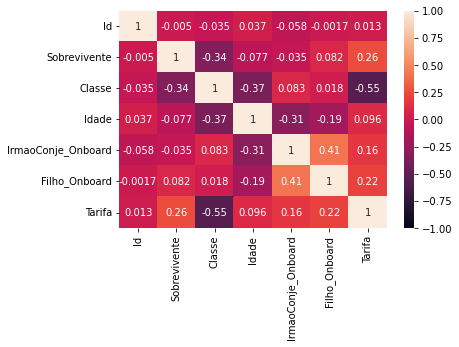

In [ ]:
#Plot da matriz de correlação
sns.heatmap(df_train.corr(), annot=True, vmin=-1, vmax=1);

3 - Valores nulos ?

In [ ]:
df_train.isnull().sum()

Id                      0
Sobrevivente            0
Classe                  0
Nome                    0
Genero                  0
Idade                 177
IrmaoConje_Onboard      0
Filho_Onboard           0
Ticket                  0
Tarifa                  0
Cabine                687
Local_Embarque          2
dtype: int64

In [ ]:
#Encontramos 177 entidades sem idade, o que fazer?


In [ ]:
#Aplicamos a média por genero e classe, nas idades que estão faltando

data = [df_train, df_test]
for dataset in data:
  dataset['Idade'] = dataset['Idade'].groupby([dataset['Genero'], dataset['Classe']]).apply(lambda x : x.fillna(x.mean()))


In [ ]:
df_train.isnull().sum()

Id                      0
Sobrevivente            0
Classe                  0
Nome                    0
Genero                  0
Idade                   0
IrmaoConje_Onboard      0
Filho_Onboard           0
Ticket                  0
Tarifa                  0
Cabine                687
Local_Embarque          2
dtype: int64

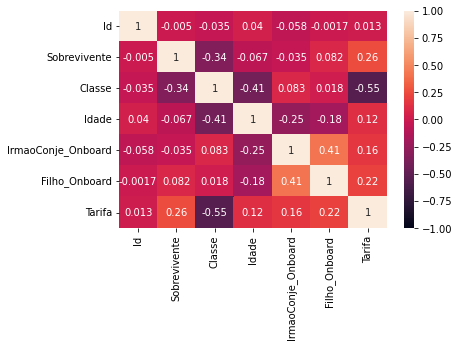

In [ ]:
sns.heatmap(df_train.corr(), annot=True, vmin=-1, vmax=1);

In [ ]:
#Outro ponto interessate são as cabines, que eram marcadas pelo Letra do deck seguida do numero.
# Quanto maior a letra no deck, mais proxima a agua a cabine estava
#Então substituir por numeros, quanto maior, mais baixo no navio
df_train.isnull().sum()

Id                      0
Sobrevivente            0
Classe                  0
Nome                    0
Genero                  0
Idade                   0
IrmaoConje_Onboard      0
Filho_Onboard           0
Ticket                  0
Tarifa                  0
Cabine                687
Local_Embarque          2
dtype: int64

In [ ]:
import numpy as np

deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 8, "0": 0}

data = [df_train, df_test]
for dataset in data:
  dataset['Deck'] = dataset.Cabine.apply(lambda x : x[0:1] if pd.notnull(x) else x)
  dataset['Deck'] = dataset['Deck'].map(deck)
  dataset['Deck'] = dataset['Deck'].groupby([dataset['Genero'], dataset['Classe']]).apply(lambda x : x.fillna(np.ceil(x.describe().mean())))
  dataset.drop(columns='Cabine', inplace=True)


df_train.select_dtypes(include='object')

,Nome,Genero,Ticket,Local_Embarque
0,"Braund, Mr. Owen Harris",male,A/5 21171,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,S
4,"Allen, Mr. William Henry",male,373450,S
...,...,...,...,...
886,"Montvila, Rev. Juozas",male,211536,S
887,"Graham, Miss. Margaret Edith",female,112053,S
888,"Johnston, Miss. Catherine Helen ""Carrie""",female,W./C. 6607,S
889,"Behr, Mr. Karl Howell",male,111369,C


In [ ]:
df_train.isnull().sum()

Id                    0
Sobrevivente          0
Classe                0
Nome                  0
Genero                0
Idade                 0
IrmaoConje_Onboard    0
Filho_Onboard         0
Ticket                0
Tarifa                0
Local_Embarque        2
Deck                  0
dtype: int64

In [ ]:
df_train.head()

,Id,Sobrevivente,Classe,Nome,Genero,Idade,IrmaoConje_Onboard,Filho_Onboard,Ticket,Tarifa,Local_Embarque,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,6.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,3.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,6.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,3.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,6.0


In [ ]:
df_test.isna().sum()

Id                    0
Classe                0
Nome                  0
Genero                0
Idade                 0
IrmaoConje_Onboard    0
Filho_Onboard         0
Ticket                0
Tarifa                1
Local_Embarque        0
Sobrevivente          0
Deck                  0
dtype: int64

In [ ]:
df_train.isna().sum()

Id                    0
Sobrevivente          0
Classe                0
Nome                  0
Genero                0
Idade                 0
IrmaoConje_Onboard    0
Filho_Onboard         0
Ticket                0
Tarifa                0
Local_Embarque        2
Deck                  0
dtype: int64

In [ ]:
#No dataset de treino, temos dois passageiros sem o local de embarque e no de teste, temos um passageiro sem tarifa.
#Para os passageiros sem local de embarque vamos aplicar o local mais comum, já para o sem tarifa, iremos aplicar a media da tarfica por classe e genero


In [ ]:
df_train.Local_Embarque.value_counts()

S    644
C    168
Q     77
Name: Local_Embarque, dtype: int64

In [ ]:
df_train.Local_Embarque.fillna('S', inplace=True)
df_train.isnull().sum()

Id                    0
Sobrevivente          0
Classe                0
Nome                  0
Genero                0
Idade                 0
IrmaoConje_Onboard    0
Filho_Onboard         0
Ticket                0
Tarifa                0
Local_Embarque        0
Deck                  0
dtype: int64

In [ ]:
df_test.loc[df_test['Tarifa'].isna()]

,Id,Classe,Nome,Genero,Idade,IrmaoConje_Onboard,Filho_Onboard,Ticket,Tarifa,Local_Embarque,Sobrevivente,Deck
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S,0,5.0


In [ ]:

df_test['Tarifa'] = dataset['Tarifa'].groupby([dataset['Genero'], dataset['Classe']]).apply(lambda x : x.fillna(x.mean()))
df_test.loc[df_test['Id']== 1044]


,Id,Classe,Nome,Genero,Idade,IrmaoConje_Onboard,Filho_Onboard,Ticket,Tarifa,Local_Embarque,Sobrevivente,Deck
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,11.82635,S,0,5.0


In [ ]:
df_test.isnull().sum()

Id                    0
Classe                0
Nome                  0
Genero                0
Idade                 0
IrmaoConje_Onboard    0
Filho_Onboard         0
Ticket                0
Tarifa                0
Local_Embarque        0
Sobrevivente          0
Deck                  0
dtype: int64

In [ ]:
#Nesse ponto não temos mais "falta de dados"

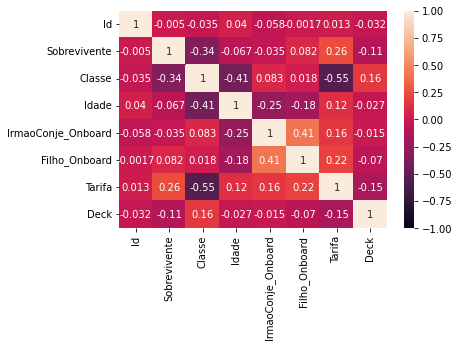

In [ ]:
sns.heatmap(df_train.corr(), annot=True, vmin=-1, vmax=1);

In [ ]:
df_train.select_dtypes(include='object')

,Nome,Genero,Ticket,Local_Embarque
0,"Braund, Mr. Owen Harris",male,A/5 21171,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,S
4,"Allen, Mr. William Henry",male,373450,S
...,...,...,...,...
886,"Montvila, Rev. Juozas",male,211536,S
887,"Graham, Miss. Margaret Edith",female,112053,S
888,"Johnston, Miss. Catherine Helen ""Carrie""",female,W./C. 6607,S
889,"Behr, Mr. Karl Howell",male,111369,C


In [ ]:
#Após analisar a matriz de correlação, podemos tomar alguns caminhos

# Separar em duas colunas(Homem e Mulher) já que Genero não aprece por ser do tipo categorico
# Juntar Filho e Irmão Conje em uma nova coluna "Sozinho"
#Isso deverá nos dar novas correlações

In [ ]:
df_train = pd.get_dummies(df_train, columns=['Genero'])

df_test = pd.get_dummies(df_test, columns=['Genero'])

df_train

,Id,Sobrevivente,Classe,Nome,Idade,IrmaoConje_Onboard,Filho_Onboard,Ticket,Tarifa,Local_Embarque,Deck,Genero_female,Genero_male
0,1,0,3,"Braund, Mr. Owen Harris",22.00,1,0,A/5 21171,7.2500,S,6.0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.00,1,0,PC 17599,71.2833,C,3.0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26.00,0,0,STON/O2. 3101282,7.9250,S,6.0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.00,1,0,113803,53.1000,S,3.0,1,0
4,5,0,3,"Allen, Mr. William Henry",35.00,0,0,373450,8.0500,S,6.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",27.00,0,0,211536,13.0000,S,5.0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",19.00,0,0,112053,30.0000,S,2.0,1,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",21.75,1,2,W./C. 6607,23.4500,S,6.0,1,0
889,890,1,1,"Behr, Mr. Karl Howell",26.00,0,0,111369,30.0000,C,3.0,0,1


In [ ]:
data = [df_train, df_test]
for dataset in data:
  dataset['Sozinho'] = (dataset['IrmaoConje_Onboard'] + dataset['Filho_Onboard']).apply(lambda x : 0 if x > 0 else 1)
  dataset.drop(columns=['Filho_Onboard', 'IrmaoConje_Onboard'], inplace=True)


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              418 non-null    int64  
 1   Classe          418 non-null    int64  
 2   Nome            418 non-null    object 
 3   Idade           418 non-null    float64
 4   Ticket          418 non-null    object 
 5   Tarifa          418 non-null    float64
 6   Local_Embarque  418 non-null    object 
 7   Sobrevivente    418 non-null    int64  
 8   Deck            418 non-null    float64
 9   Genero_female   418 non-null    uint8  
 10  Genero_male     418 non-null    uint8  
 11  Sozinho         418 non-null    int64  
dtypes: float64(3), int64(4), object(3), uint8(2)
memory usage: 56.7+ KB


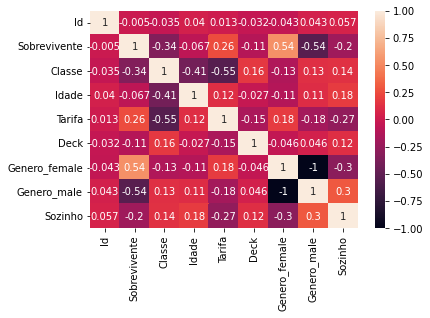

In [ ]:
sns.heatmap(df_train.corr(), annot=True, vmin=-1, vmax=1);

In [ ]:
#Outro tratamento interessante é agrupar as idades


idade_grupo = [0, 11, 17, 25, 35, 45, 55, 65, 100]
idade_grupo_nomes = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H']

data = [df_train, df_test]
for dataset in data:
  dataset['Grupo_Idade'] = pd.cut(dataset.Idade, bins=idade_grupo, labels=idade_grupo_nomes)
  dataset.drop(columns=['Idade'], inplace=True)
  
df_train.head()

,Id,Sobrevivente,Classe,Nome,Ticket,Tarifa,Local_Embarque,Deck,Genero_female,Genero_male,Sozinho,Grupo_Idade
0,1,0,3,"Braund, Mr. Owen Harris",A/5 21171,7.2500,S,6.0,0,1,0,C
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C,3.0,1,0,0,E
2,3,1,3,"Heikkinen, Miss. Laina",STON/O2. 3101282,7.9250,S,6.0,1,0,1,D
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,S,3.0,1,0,0,D
4,5,0,3,"Allen, Mr. William Henry",373450,8.0500,S,6.0,0,1,1,D


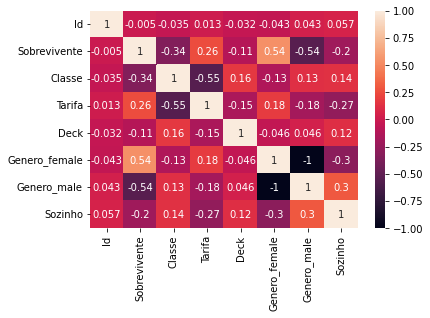

In [ ]:
sns.heatmap(df_train.corr(), annot=True, vmin=-1, vmax=1);

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Id              891 non-null    int64   
 1   Sobrevivente    891 non-null    int64   
 2   Classe          891 non-null    int64   
 3   Nome            891 non-null    object  
 4   Ticket          891 non-null    object  
 5   Tarifa          891 non-null    float64 
 6   Local_Embarque  891 non-null    object  
 7   Deck            891 non-null    float64 
 8   Genero_female   891 non-null    uint8   
 9   Genero_male     891 non-null    uint8   
 10  Sozinho         891 non-null    int64   
 11  Grupo_Idade     891 non-null    category
dtypes: category(1), float64(2), int64(4), object(3), uint8(2)
memory usage: 65.8+ KB


In [ ]:
#Outra tratamento interessante é agrupar as idades
Faixa_etaria = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9}
data = [df_train, df_test]

for dataset in data:
    dataset['Tarifa'] = dataset['Tarifa'].astype(int)
    dataset['Deck'] = dataset['Deck'].astype(int)

    dataset['Grupo_Idade'] = dataset['Grupo_Idade'].map(Faixa_etaria)
    dataset['Grupo_Idade'] = dataset['Grupo_Idade'].astype(int)

df_train

,Id,Sobrevivente,Classe,Nome,Ticket,Tarifa,Local_Embarque,Deck,Genero_female,Genero_male,Sozinho,Grupo_Idade
0,1,0,3,"Braund, Mr. Owen Harris",A/5 21171,7,S,6,0,1,0,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71,C,3,1,0,0,5
2,3,1,3,"Heikkinen, Miss. Laina",STON/O2. 3101282,7,S,6,1,0,1,4
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53,S,3,1,0,0,4
4,5,0,3,"Allen, Mr. William Henry",373450,8,S,6,0,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",211536,13,S,5,0,1,1,4
887,888,1,1,"Graham, Miss. Margaret Edith",112053,30,S,2,1,0,1,3
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",W./C. 6607,23,S,6,1,0,0,3
889,890,1,1,"Behr, Mr. Karl Howell",111369,30,C,3,0,1,1,4


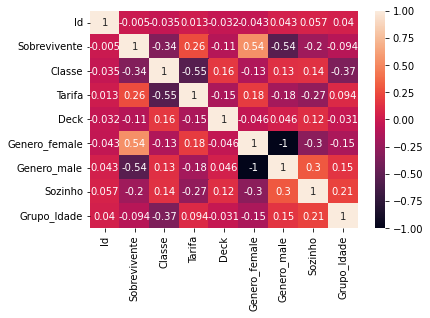

In [ ]:
sns.heatmap(df_train.corr(), annot=True, vmin=-1, vmax=1);

In [ ]:
#Vamos remover o nome e o ticket, que a principio não iremos utilizar
data = [df_train, df_test]

for dataset in data:
    dataset.drop(columns=['Nome', 'Ticket'], inplace=True)


df_train

,Id,Sobrevivente,Classe,Tarifa,Local_Embarque,Deck,Genero_female,Genero_male,Sozinho,Grupo_Idade
0,1,0,3,7,S,6,0,1,0,3
1,2,1,1,71,C,3,1,0,0,5
2,3,1,3,7,S,6,1,0,1,4
3,4,1,1,53,S,3,1,0,0,4
4,5,0,3,8,S,6,0,1,1,4
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,13,S,5,0,1,1,4
887,888,1,1,30,S,2,1,0,1,3
888,889,0,3,23,S,6,1,0,0,3
889,890,1,1,30,C,3,0,1,1,4


In [ ]:
#Vamos subistituir as portas de embarque por números
ports = {"S": 0, "C": 1, "Q": 2}
data = [df_train, df_test]

for dataset in data:
    dataset['Local_Embarque'] = dataset['Local_Embarque'].map(ports)

df_train

,Id,Sobrevivente,Classe,Tarifa,Local_Embarque,Deck,Genero_female,Genero_male,Sozinho,Grupo_Idade
0,1,0,3,7,0,6,0,1,0,3
1,2,1,1,71,1,3,1,0,0,5
2,3,1,3,7,0,6,1,0,1,4
3,4,1,1,53,0,3,1,0,0,4
4,5,0,3,8,0,6,0,1,1,4
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,13,0,5,0,1,1,4
887,888,1,1,30,0,2,1,0,1,3
888,889,0,3,23,0,6,1,0,0,3
889,890,1,1,30,1,3,0,1,1,4


In [ ]:
#Agora vamos remover o id e campo "sobrevivente" que indica se o passageiro sobreviveu ou não ao naufragio da Titanic
X_train = df_train.drop(["Sobrevivente", "Id"], axis=1)
Y_train = df_train["Sobrevivente"]

X_test= df_test.drop(["Sobrevivente", "Id"], axis=1)
Y_test = df_test["Sobrevivente"]


In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
#Modelos de classificação
modelos = [LogisticRegression(solver='liblinear'), RandomForestClassifier(n_estimators=400, random_state=42),
           DecisionTreeClassifier(random_state=42), SVC(kernel='linear', gamma='scale', random_state=42),
           KNeighborsClassifier()]

In [ ]:
#Validação cruzada
mean=[]
std=[]
for model in modelos:
  result = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy', n_jobs=-1)
  mean.append(result)
  std.append(result)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

([], <a list of 0 Text major ticklabel objects>)

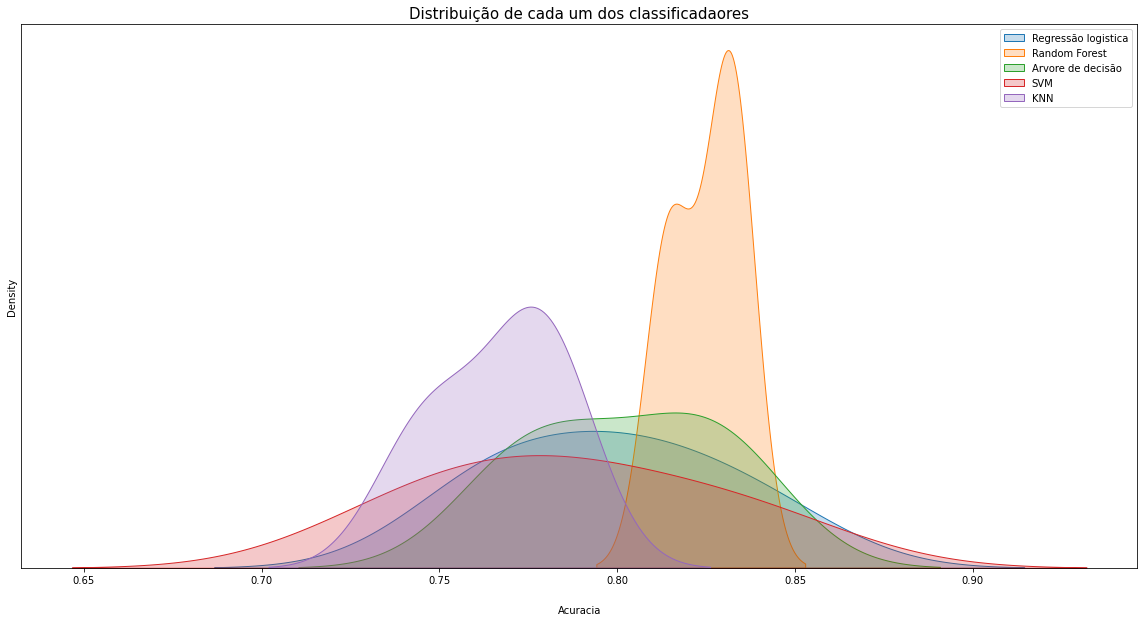

In [ ]:
classificadores = ['Regressão logistica', 'Random Forest', 'Arvore de decisão', 'SVM', 'KNN']

plt.figure(figsize=(20, 10))
for i in range(len(mean)):
  sns.distplot(mean[i], hist=False, kde_kws={"shade":True})

plt.title("Distribuição de cada um dos classificadaores", fontsize=15)
plt.legend(classificadores)
plt.xlabel("Acuracia", labelpad=20)
plt.yticks([])

In [ ]:

svc_clf = SVC(C=0.9, gamma=0.1, kernel='linear', probability=True, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=42)
dt_clf = DecisionTreeClassifier(random_state=42)
knn_clf =  KNeighborsClassifier()
lr_clf = LogisticRegression(solver='liblinear')

svc_clf.fit(X_train, Y_train)
rf_clf.fit(X_train, Y_train)
dt_clf.fit(X_train, Y_train)
knn_clf.fit(X_train, Y_train)
lr_clf.fit(X_train, Y_train)

LogisticRegression(solver='liblinear')

In [ ]:
svc_prob = svc_clf.predict_proba(X_test)
rf_prob = rf_clf.predict_proba(X_test)
dt_prob = dt_clf.predict_proba(X_test)
knn_prob = knn_clf.predict_proba(X_test)
lr_prob = lr_clf.predict_proba(X_test)

svc_preds = np.argmax(svc_prob, axis=1)
rf_preds = np.argmax(rf_prob, axis=1)
dt_preds = np.argmax(dt_prob, axis=1)
knn_preds = np.argmax(knn_prob, axis=1)
lr_preds = np.argmax(lr_prob, axis=1)

In [ ]:
cm = metrics.confusion_matrix(Y_test, svc_preds)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

cm2 = metrics.confusion_matrix(Y_test, rf_preds)
cm2 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]

cm3 = metrics.confusion_matrix(Y_test, dt_preds)
cm3 = cm3.astype('float') / cm3.sum(axis=1)[:, np.newaxis]

cm4 = metrics.confusion_matrix(Y_test, knn_preds)
cm4 = cm4.astype('float') / cm4.sum(axis=1)[:, np.newaxis]

cm5 = metrics.confusion_matrix(Y_test, lr_preds)
cm5 = cm5.astype('float') / cm5.sum(axis=1)[:, np.newaxis]


[Text(1634.3793103448277, 0.5, 'Valor real'), Text(0.5, 24.0, 'previsão')]

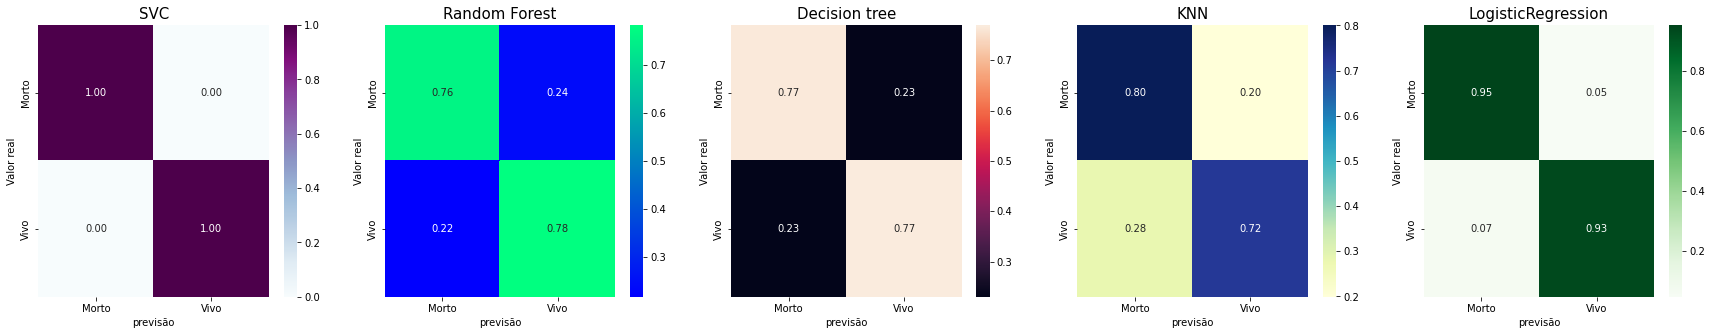

In [ ]:
from IPython.core.pylabtools import figsize
classes=["Morto", "Vivo"]
f, ax = plt.subplots(1, 5,  figsize=(30, 5))

ax[0].set_title("SVC", fontsize=15.)
sns.heatmap(pd.DataFrame(cm, index=classes, columns=classes),
            cmap="BuPu", annot=True, fmt='.2f', ax=ax[0]).set(xlabel="previsão", ylabel="Valor real")

ax[1].set_title("Random Forest", fontsize=15.)
sns.heatmap(pd.DataFrame(cm2, index=classes, columns=classes),
            cmap='winter', annot=True, fmt='.2f', ax=ax[1]).set(xlabel="previsão", ylabel="Valor real")

ax[2].set_title("Decision tree", fontsize=15.)
sns.heatmap(pd.DataFrame(cm3, index=classes, columns=classes)
            , annot=True, fmt='.2f', ax=ax[2]).set(xlabel="previsão", ylabel="Valor real")

ax[3].set_title("KNN", fontsize=15.)
sns.heatmap(pd.DataFrame(cm4, index=classes, columns=classes),
            cmap='YlGnBu', annot=True, fmt='.2f', ax=ax[3]).set(xlabel="previsão", ylabel="Valor real")

ax[4].set_title("LogisticRegression", fontsize=15.)
sns.heatmap(pd.DataFrame(cm5, index=classes, columns=classes),
            cmap='Greens', annot=True, fmt='.2f', ax=ax[4]).set(xlabel="previsão", ylabel="Valor real")